# Compute False Positives and Negatives for Each Label Type

This should help with error analysis

We take as input the .csv exported from the save_classifications.py file

In [1]:
import os
import csv
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import shutil
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [20]:
num_to_sample = 75

In [21]:
predictions_csv = 'gt_20ep_cc_re18_2ff2.csv' # using ground truth

dataset_path = '/mnt/g/ground_truth_cc_dataset'

output_path = 'output_true'
if not os.path.isdir(output_path):
    os.mkdir(output_path)

In [15]:
false_pos = defaultdict(set)
# these are things that shouldn't have been labeled as [label] but were

false_neg = defaultdict(set)
# these are things that should have been labeled as [label] but weren't

true_pos = defaultdict(set)
# correct!

In [16]:
with open(predictions_csv) as f:
    reader = csv.DictReader(f)
    num_items = 0
    num_wrong = 0
    for item in reader:
        num_items += 1
        actual    = item['Actual']
        predicted = item['Predicted']
        
        if actual != predicted:
            num_wrong += 1
            false_pos[predicted].add(item['File'])
            false_neg[actual   ].add(item['File'])
        
        else:
            true_pos[actual].add(item['File'])
            
print "Counted {} items, {:5.2f}% correct.".format(num_items, 100*(float(num_items - num_wrong)/num_items))
print ""
print "{:<15} {:<5} {:<5}".format("Label", "#FP", "#FN")
for label, fp in false_pos.items():
    fn = false_neg[label]
    print "{:<15} {:<5} {:<5}".format(label, len(fp), len(fn))

Counted 1392 items, 66.88% correct.

Label           #FP   #FN  
sfc_problem     17    140  
obstruction     101   48   
null            19    166  
ramp            243   50   
missing_ramp    81    57   


In [6]:
# premade example here https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.set_size_inches(8,8)
    fig.tight_layout()
    return ax

In [7]:
pretty_labels = ('Ramp', 'Missing Ramp', 'Sfc Problem', 'Obstruction', 'Null')
ugly_labels   = ('ramp', 'missing_ramp', 'sfc_problem', 'obstruction', 'null')

y_true = []
y_pred = []

with open(predictions_csv) as f:
    reader = csv.DictReader(f)
    num_items = 0
    for item in reader:
        num_items += 1
        actual    = ugly_labels.index(item['Actual'])
        predicted = ugly_labels.index(item['Predicted'])
        
        y_true.append(actual)
        y_pred.append(predicted)

Normalized confusion matrix
[[0.92050874 0.02384738 0.00317965 0.03656598 0.01589825]
 [0.3255814  0.55813953 0.         0.09302326 0.02325581]
 [0.36744186 0.11162791 0.34883721 0.15348837 0.01860465]
 [0.28571429 0.03571429 0.00714286 0.65714286 0.01428571]
 [0.29390681 0.13261649 0.05017921 0.11827957 0.40501792]]


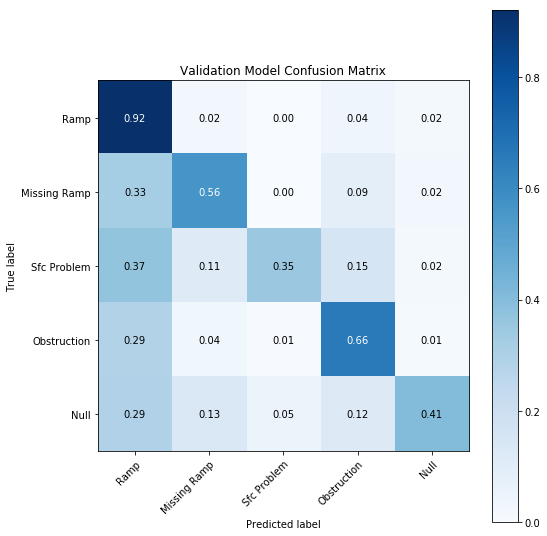

In [8]:
plot_confusion_matrix(y_true, y_pred, np.array(pretty_labels), normalize=True,title="Validation Model Confusion Matrix",cmap=plt.cm.Blues)
plt.show()

# copy predictions to directories

In [22]:
#for kind, d in (('false_pos', false_pos), ('false_neg', false_neg), ('true_pos', true_pos)):
for kind, d in (('true_pos', true_pos),):

    if not os.path.isdir( os.path.join(output_path, kind) ):
        os.mkdir( os.path.join(output_path, kind) )
    
    for label, paths in d.items():
        if len(paths) > num_to_sample:
            sample = random.sample(paths, num_to_sample)
        else: sample = paths
        for shortpath in sample:
            completepath = os.path.join(dataset_path, shortpath)
            _, filename = os.path.split(shortpath)
            destdir = os.path.join(output_path, kind, label)
            if not os.path.isdir(destdir):
                os.mkdir(destdir)
            destpath = os.path.join(destdir, filename)
            shutil.copy(completepath, destpath)